In [28]:
import pyquil.api as api
from pyquil import Program
from qRBM_final import qRBM
from pyquil.gates import *
from random import *
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import log_loss 
from sklearn import svm
from sklearn.neural_network import BernoulliRBM
from datetime import datetime

In [29]:
def train_classical(num_epochs=20, num_hidden=2):
    model = BernoulliRBM(n_components=num_hidden, n_iter=num_epochs)
    model.fit(artificial_data)
    return model

In [30]:
def train(num_epochs=20, num_hidden=2, gate_noise_probs=None, meas_noise_probs=None, n_quantum_measurements=None):
    '''
    gate_noise_probs:       PX, PY, PZ gates getting applied to each qubit after every gate application
    meas_noise_probs:       PX, PY, PZ gates getting applied to the qubit being measured before it is measured
    n_quantum_measurements: None means "analytical" measurement to save time on simulation

    '''
    qvm = api.QVMConnection(gate_noise=gate_noise_probs, measurement_noise=meas_noise_probs)
    qr = qRBM(qvm, num_visible=4, num_hidden=num_hidden, n_quantum_measurements=n_quantum_measurements)
    qr.train(artificial_data, n_epochs=num_epochs)
    return qr, max_prob_list(qr.pred_list)

In [31]:
def max_prob_list(pred_list):
    max_prob_list = []
    for epoch_pred in pred_list:
        max_prob_list.append(np.max(epoch_pred))
    return max_prob_list

In [32]:
def plot_score(score_list, hidden_state):
    plt.plot(score_list, marker='o', label="Hidden State: " + str(hidden_state))
    # plt.ylim(0, 1)
    plt.xlabel('# Epochs')
    plt.ylabel('Accuracy')
    plt.title('Hidden States: Accuracy vs Epochs') 
    plt.legend()
    plt.ylim(0, 1.1)

In [36]:
def evaluate_hidden_states(num_epochs, num_hidden_list, n_quantum_measurements):
    prob_list = []
    model_list = []
    time_list = []
    for num_hidden in num_hidden_list:
        time1 = datetime.now()
        model, prob = train(num_epochs=num_epochs, 
                            num_hidden=num_hidden,
                            n_quantum_measurements=n_quantum_measurements)
        time2 = datetime.now()
        time_list.append((time2 - time1).total_seconds())
        prob_list.append(prob)
        model_list.append(model)
    return time_list, prob_list, model_list

In [37]:
def evaluate_hidden_states_classical(num_epochs, num_hidden_list):
    prob_list = []
    model_list = []
    time_list = []
    for num_hidden in num_hidden_list:
        time1 = datetime.now()
        model = BernoulliRBM(n_components=num_hidden, n_iter=num_epochs)
        model.fit(artificial_data)
        time2 = datetime.now()
        time_list.append((time2 - time1).total_seconds())
        prob = model.transform(artificial_data)
        prob_list.append(prob)
        model_list.append(model)
    return time_list, prob_list, model_list

In [38]:
def classical_rbm_eval(num_epochs, classical_prob_list, hidden_state):
    y = random_coin
    scores = []
    for epoch in range(num_epochs):
        X = classical_prob_list[hidden_state][epoch]
        clf = svm.SVC()
        clf.fit(X, y)
        scores.append(clf.score(X,y))
    return scores

In [39]:
def quantum_rbm_eval(num_epochs, hidden_model_list, hidden_state):
    y = random_coin
    scores = []
    for epoch in range(num_epochs):
        X = hidden_model_list[hidden_state].pred_list[epoch]
        clf = svm.SVC()
        clf.fit(X, y)
        scores.append([clf.score(X,y)])
    return scores

## Creating the underlying distribution
We flip an unbiased coin to generate a sequence of random bits, this will be the underlying hidden distribution of our data.

In [40]:
#flip a coin
np.random.seed(1234)
random_coin = np.random.choice(np.arange(0,8), size=150, replace=True)
random_coin

array([7, 3, 6, 5, 4, 4, 0, 1, 7, 1, 7, 1, 2, 6, 3, 6, 4, 4, 2, 6, 2, 0,
       0, 4, 5, 0, 1, 7, 6, 6, 7, 2, 0, 3, 4, 5, 2, 6, 2, 3, 7, 3, 0, 1,
       3, 0, 3, 2, 3, 4, 1, 3, 3, 3, 2, 1, 6, 3, 7, 4, 2, 3, 6, 4, 1, 7,
       5, 4, 0, 4, 5, 5, 1, 7, 5, 7, 1, 4, 1, 4, 5, 0, 1, 0, 0, 4, 6, 0,
       6, 4, 2, 3, 7, 1, 2, 5, 6, 2, 5, 5, 6, 7, 4, 3, 5, 6, 7, 6, 4, 6,
       7, 7, 2, 2, 4, 4, 2, 7, 1, 7, 3, 6, 7, 2, 1, 6, 7, 4, 1, 0, 1, 2,
       1, 2, 1, 2, 1, 1, 5, 7, 4, 7, 7, 1, 2, 4, 0, 5, 4, 1])

## Generating encoded sequences

In [41]:
#Encode this coin flip in to an artifically high dimensional dataset
artificial_data = []
for flip in random_coin:
    if flip == 0:
        artificial_data.append([0,0,0,0])
    elif flip == 1:
        artificial_data.append([0,0,0,1])
    elif flip == 2:
        artificial_data.append([0,0,1,0])
    elif flip == 3:
        artificial_data.append([0,0,1,1])
    elif flip == 4:
        artificial_data.append([0,1,0,0])
    elif flip == 5:
        artificial_data.append([0,1,0,1])
    elif flip == 6:
        artificial_data.append([0,1,1,0])
    elif flip == 7:
        artificial_data.append([0,1,1,1])
    elif flip == 8:
        artificial_data.append([1,0,0,0])
    elif flip == 9:
        artificial_data.append([1,0,0,1])
    elif flip == 10:
        artificial_data.append([1,0,1,0])
    elif flip == 11:
        artificial_data.append([1,0,1,1])
    elif flip == 12:
        artificial_data.append([1,1,0,0])
    elif flip == 13:
        artificial_data.append([1,1,0,1])
    elif flip == 14:
        artificial_data.append([1,1,1,0])
    else:
        artificial_data.append([1,1,1,1])

#We know have an artificially high dimensional dataset that still only has the 1 bit coin flip dictating
#the underlying distribution
artificial_data = np.asarray(artificial_data)
artificial_data.shape

(150, 4)

## Experiment Settings

In [54]:
num_epochs = 5
num_hidden_list = [1, 2, 3, 4, 5]

In [55]:
%%capture
q_time_list, hidden_prob_list, hidden_model_list = evaluate_hidden_states(num_epochs=num_epochs, 
                                                      num_hidden_list=num_hidden_list, 
                                                      n_quantum_measurements=None,)

In [56]:
c_time_list, classical_prob_list, classical_model_list = evaluate_hidden_states_classical(num_epochs, 
                                                                                          num_hidden_list)

Text(0.5, 1.0, 'Hidden States time complexity analysis')

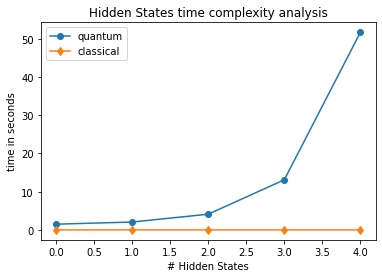

In [62]:
plt.plot(q_time_list, label='quantum', marker='o')
plt.plot(c_time_list, label='classical', marker='d')
plt.legend()
plt.xlabel('# Hidden States')
plt.ylabel('time in seconds')
plt.title('Hidden States time complexity analysis')